In [1]:
%pip install git+https://github.com/metadriverse/metadrive.git
!pip install stable-baselines3  # For PPO experiments
!pip install gym  # Ensure gym is installed


  Cloning https://github.com/metadriverse/metadrive.git to /tmp/pip-req-build-zff7u3fg
  Running command git clone --filter=blob:none --quiet https://github.com/metadriverse/metadrive.git /tmp/pip-req-build-zff7u3fg
  Resolved https://github.com/metadriverse/metadrive.git to commit b908149e422f2e7715207ca1eb81380342de5681
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.4 MB/s eta 0:00:00
  Created wheel for metadrive-simulator: filename=metadrive_simulator-0.4.3-py3-none-any.whl size=55022091 sha256=1eaab

In [2]:
!apt-get install -y xvfb python-opengl ffmpeg

!pip install pyvirtualdisplay

!sudo apt-get update
!sudo apt-get install -y xvfb


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,364 kB]
Get:12 htt

In [3]:
import os
import numpy as np
from stable_baselines3 import PPO
from metadrive.envs import MetaDriveEnv
from pyvirtualdisplay import Display
from PIL import Image
from IPython.display import display as ipy_display, clear_output
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback


/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [84]:
class PerformanceLogger(BaseCallback):
    def __init__(self, verbose=0):
        super(PerformanceLogger, self).__init__(verbose)
        self.timesteps = []
        self.rewards = []
        self.current_reward = 0

    def reset(self):
        """Reset the logger for a new training phase."""
        self.current_reward = 0


    def _on_step(self) -> bool:
        # Sum rewards from this step
        self.current_reward += sum(self.locals["rewards"])

        # Log rewards at the end of a rollout
        if self.n_calls % self.model.n_steps == 0:
            self.timesteps.append(self.num_timesteps)
            self.rewards.append(self.current_reward / self.model.n_steps)  # Average reward per step
            self.current_reward = 0  # Reset for next rollout
        return True


In [100]:
# Function to create the environment
def create_environment(difficulty, render=False, monitor=True):
    configs = {
        "easy": {"map": "C", "traffic_density": 0.1, "random_lane_width": False, "use_render": render,
                            #  "out_of_road_penalty": 30.0,  # Increased penalty
                #  "out_of_road_cost":


                 },
        "medium": {"map": "C", "traffic_density": 0.3, "random_lane_width": True, "use_render": render,
                              #  "out_of_road_penalty": 30.0,  # Increased penalty

                   },
        "hard": {"map": "C", "traffic_density": 0.5, "random_lane_width": True, "use_render": render},
    }

    base_env = MetaDriveEnv(configs[difficulty])
    if monitor:
        return Monitor(base_env)
    else:
      return base_env

In [101]:
def train_agent_with_transfer(env, timesteps=1000, model=None):
    logger = PerformanceLogger()
    if model is None:
        model = PPO("MlpPolicy", env, verbose=2, n_steps=4096) #changing n_step param significantly changes reward results, should play ard with this
    else:
        print("Continuing training with transfer learning...")
    logger.reset()  # Reset logger for the new training phase
    model.learn(total_timesteps=timesteps, callback=logger)
    return model, logger

In [102]:
def plot_performance(logger, title= 'Agent Performance'):
    """
    Plot the logged performance data.
    """
    if not logger.timesteps or not logger.rewards:
        print("[ERROR] No data to plot. Ensure rewards are logged during training.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(logger.timesteps, logger.rewards, label="Episode Rewards")
    plt.xlabel("Timesteps")
    plt.ylabel("Rewards")
    plt.title("Agent Performance Over Timesteps")
    plt.legend()
    plt.grid()
    plt.show()

In [103]:
# Curriculum experiment without transfer learning
def curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=10000):
    results = []
    models = []
    for difficulty in difficulty_order:
        print(f"Training on {difficulty} difficulty (No Transfer)...")
        env = create_environment(difficulty, render=False)
        try:
            model, logger = train_agent_with_transfer(env, timesteps=timesteps_per_difficulty)
            results.append((difficulty, logger))
            models.append((difficulty, model))
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(logger, f"Performance on {difficulty} (No Transfer)")
    return results,  models

In [104]:
# Curriculum experiment with transfer learning
def curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=1000):
    model = None  # Start with no pretrained model
    logger = PerformanceLogger()
    results = []
    models = []

    for difficulty in difficulty_order:
        print(f"Training on {difficulty} difficulty (With Transfer)...")
        env = create_environment(difficulty, render=False)
        try:
            model, logger = train_agent_with_transfer(env, model=model, timesteps=timesteps_per_difficulty)
            results.append((difficulty, logger))
            models.append((difficulty, model))
        except Exception as e:
            print(f"Error during training on {difficulty} difficulty: {e}")
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(logger, f"Performance on {difficulty} (With Transfer)")
    return results, models

In [110]:
# Run the curriculum experiments
difficulty_order = ["easy", ]#"medium"#, "hard"]

# Experiment without transfer learning
# print("Running Curriculum Experiment WITHOUT Transfer Learning...")
# curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=500)

# # Experiment with transfer learning
# print("Running Curriculum Experiment WITH Transfer Learning...")
# curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=500)

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on easy difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.04e+03 |
|    ep_rew_mean     | -15.6    |
| time/              |          |
|    fps             | 205      |
|    iterations      | 1        |
|    time_elapsed    | 19       |
|    total_timesteps | 4096     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.04e+03     |
|    ep_rew_mean          | -15.6        |
| time/                   |              |
|    fps                  | 198          |
|    iterations           | 2            |
|    time_elapsed         | 41           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0072540566 |
|    clip_fraction        | 0.119        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.00259      |
|    learning_r

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.42e+03    |
|    ep_rew_mean          | 10.8        |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 3           |
|    time_elapsed         | 65          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.020445108 |
|    clip_fraction        | 0.266       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.8        |
|    explained_variance   | 0.476       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0324      |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0276     |
|    std                  | 0.974       |
|    value_loss           | 0.0183      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.22e+03   |
|    ep_rew_mean          | -5.94      |
| time/                   |            |
|    fps                  | 177        |
|    iterations           | 4          |
|    time_elapsed         | 92         |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.01110029 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.78      |
|    explained_variance   | 0.00743    |
|    learning_rate        | 0.0003     |
|    loss                 | 0.355      |
|    n_updates            | 30         |
|    policy_gradient_loss | -0.0053    |
|    std                  | 0.97       |
|    value_loss           | 5.79       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.06e+03     |
|    ep_rew_mean          | -4.97        |
| time/                   |              |
|    fps                  | 174          |
|    iterations           | 5            |
|    time_elapsed         | 117          |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0045829313 |
|    clip_fraction        | 0.043        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.77        |
|    explained_variance   | -0.0081      |
|    learning_rate        | 0.0003       |
|    loss                 | 10.1         |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00211     |
|    std                  | 0.97         |
|    value_loss           | 13.3         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 968          |
|    ep_rew_mean          | -5.55        |
| time/                   |              |
|    fps                  | 172          |
|    iterations           | 6            |
|    time_elapsed         | 142          |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0060371095 |
|    clip_fraction        | 0.0473       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.77        |
|    explained_variance   | 0.0201       |
|    learning_rate        | 0.0003       |
|    loss                 | 3.8          |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.000879    |
|    std                  | 0.963        |
|    value_loss           | 13.3         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 950           |
|    ep_rew_mean          | -4.81         |
| time/                   |               |
|    fps                  | 171           |
|    iterations           | 7             |
|    time_elapsed         | 167           |
|    total_timesteps      | 28672         |
| train/                  |               |
|    approx_kl            | 0.00025458029 |
|    clip_fraction        | 0.000684      |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.76         |
|    explained_variance   | 0.0395        |
|    learning_rate        | 0.0003        |
|    loss                 | 2.54          |
|    n_updates            | 60            |
|    policy_gradient_loss | 0.00029       |
|    std                  | 0.96          |
|    value_loss           | 10.7          |
-------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 862          |
|    ep_rew_mean          | -5.52        |
| time/                   |              |
|    fps                  | 169          |
|    iterations           | 8            |
|    time_elapsed         | 192          |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0050078966 |
|    clip_fraction        | 0.0309       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.75        |
|    explained_variance   | 0.233        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.161        |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.000759    |
|    std                  | 0.957        |
|    value_loss           | 8.27         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 778          |
|    ep_rew_mean          | -6.65        |
| time/                   |              |
|    fps                  | 167          |
|    iterations           | 9            |
|    time_elapsed         | 220          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0030331328 |
|    clip_fraction        | 0.0182       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.75        |
|    explained_variance   | 0.234        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.64         |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.000179    |
|    std                  | 0.954        |
|    value_loss           | 13.4         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 768         |
|    ep_rew_mean          | -5.55       |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 10          |
|    time_elapsed         | 247         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.004413329 |
|    clip_fraction        | 0.0163      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.74       |
|    explained_variance   | 0.376       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.54        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00128    |
|    std                  | 0.953       |
|    value_loss           | 10.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 767         |
|    ep_rew_mean          | -4.42       |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 11          |
|    time_elapsed         | 271         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.005283861 |
|    clip_fraction        | 0.0926      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.74       |
|    explained_variance   | 0.756       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.646       |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00211    |
|    std                  | 0.95        |
|    value_loss           | 5.39        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 695         |
|    ep_rew_mean          | -5.4        |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 12          |
|    time_elapsed         | 300         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.007598147 |
|    clip_fraction        | 0.0969      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.71       |
|    explained_variance   | 0.354       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.27        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00205    |
|    std                  | 0.933       |
|    value_loss           | 9.23        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 623          |
|    ep_rew_mean          | -7.11        |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 13           |
|    time_elapsed         | 329          |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 0.0039984887 |
|    clip_fraction        | 0.025        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.7         |
|    explained_variance   | 0.6          |
|    learning_rate        | 0.0003       |
|    loss                 | 15.8         |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00144     |
|    std                  | 0.934        |
|    value_loss           | 13           |
------------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.16e+03 |
|    ep_rew_mean     | -5.61    |
| time/              |          |
|    fps             | 142      |
|    iterations      | 1        |
|    time_elapsed    | 28       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 913         |
|    ep_rew_mean          | -16.7       |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 2           |
|    time_elapsed         | 65          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.011788832 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | -0.0021     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.231       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00956    |
|    std                  | 0.992       |
|    value_loss           | 1.98        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.28e+03   |
|    ep_rew_mean          | -8.73      |
| time/                   |            |
|    fps                  | 127        |
|    iterations           | 3          |
|    time_elapsed         | 96         |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 0.00779838 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.82      |
|    explained_variance   | 0.000816   |
|    learning_rate        | 0.0003     |
|    loss                 | 6.16       |
|    n_updates            | 20         |
|    policy_gradient_loss | -0.00475   |
|    std                  | 0.989      |
|    value_loss           | 10.8       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.22e+03     |
|    ep_rew_mean          | -8.36        |
| time/                   |              |
|    fps                  | 121          |
|    iterations           | 4            |
|    time_elapsed         | 134          |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0040643476 |
|    clip_fraction        | 0.0248       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 0.0419       |
|    learning_rate        | 0.0003       |
|    loss                 | 4.41         |
|    n_updates            | 30           |
|    policy_gradient_loss | -9.72e-05    |
|    std                  | 0.983        |
|    value_loss           | 3.89         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.04e+03     |
|    ep_rew_mean          | -9.52        |
| time/                   |              |
|    fps                  | 116          |
|    iterations           | 5            |
|    time_elapsed         | 175          |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0092101265 |
|    clip_fraction        | 0.0896       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.0243      |
|    learning_rate        | 0.0003       |
|    loss                 | 6.19         |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00166     |
|    std                  | 0.983        |
|    value_loss           | 7.41         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 932          |
|    ep_rew_mean          | -10.6        |
| time/                   |              |
|    fps                  | 117          |
|    iterations           | 6            |
|    time_elapsed         | 208          |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0032153956 |
|    clip_fraction        | 0.00442      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 0.115        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.48         |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.000252    |
|    std                  | 0.988        |
|    value_loss           | 10.6         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 942         |
|    ep_rew_mean          | -8.86       |
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 7           |
|    time_elapsed         | 253         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.006101277 |
|    clip_fraction        | 0.0326      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.11        |
|    learning_rate        | 0.0003      |
|    loss                 | 2.68        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00165    |
|    std                  | 0.991       |
|    value_loss           | 11          |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 827         |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 8           |
|    time_elapsed         | 307         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.001666277 |
|    clip_fraction        | 0.0196      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.245       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.88        |
|    n_updates            | 70          |
|    policy_gradient_loss | -7.26e-05   |
|    std                  | 0.995       |
|    value_loss           | 7.75        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 800          |
|    ep_rew_mean          | -10          |
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 9            |
|    time_elapsed         | 353          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0040250123 |
|    clip_fraction        | 0.0253       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.422        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.14         |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.000138    |
|    std                  | 1            |
|    value_loss           | 10.6         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 811          |
|    ep_rew_mean          | -9.15        |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 10           |
|    time_elapsed         | 399          |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0040585627 |
|    clip_fraction        | 0.0375       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    explained_variance   | 0.709        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.56         |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.000874    |
|    std                  | 0.983        |
|    value_loss           | 5.11         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 828         |
|    ep_rew_mean          | -7.43       |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 11          |
|    time_elapsed         | 438         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.011060801 |
|    clip_fraction        | 0.0856      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.8        |
|    explained_variance   | 0.791       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.53        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00152    |
|    std                  | 0.981       |
|    value_loss           | 3.48        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 767         |
|    ep_rew_mean          | -7.97       |
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 12          |
|    time_elapsed         | 490         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.006197215 |
|    clip_fraction        | 0.0583      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.78       |
|    explained_variance   | 0.0888      |
|    learning_rate        | 0.0003      |
|    loss                 | 10.9        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00207    |
|    std                  | 0.962       |
|    value_loss           | 7.75        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 717          |
|    ep_rew_mean          | -8.46        |
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 13           |
|    time_elapsed         | 549          |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 0.0036231363 |
|    clip_fraction        | 0.0151       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.76        |
|    explained_variance   | 0.404        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.27         |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.000316    |
|    std                  | 0.963        |
|    value_loss           | 12.9         |
------------------------------------------
Performance for easy difficulty:


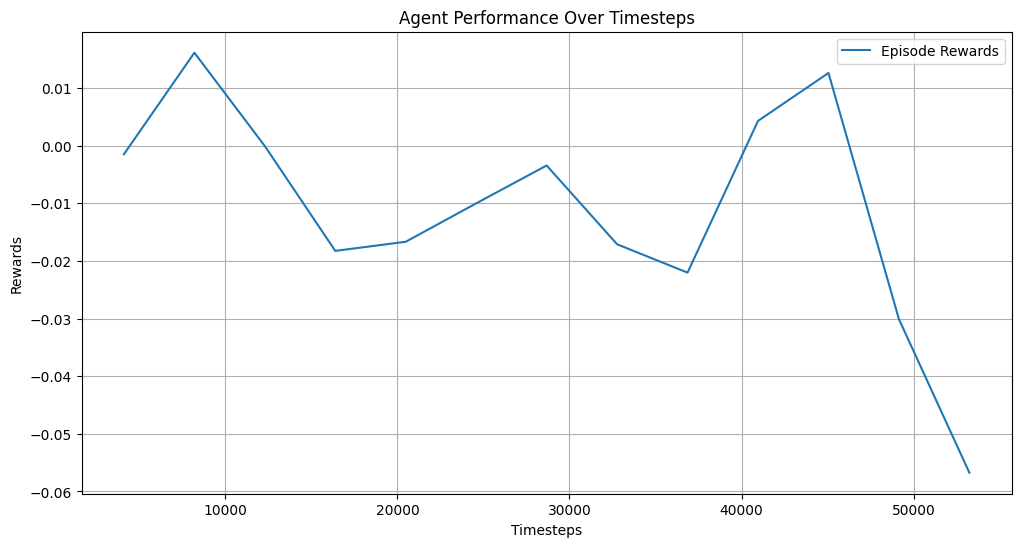

Performance for medium difficulty:


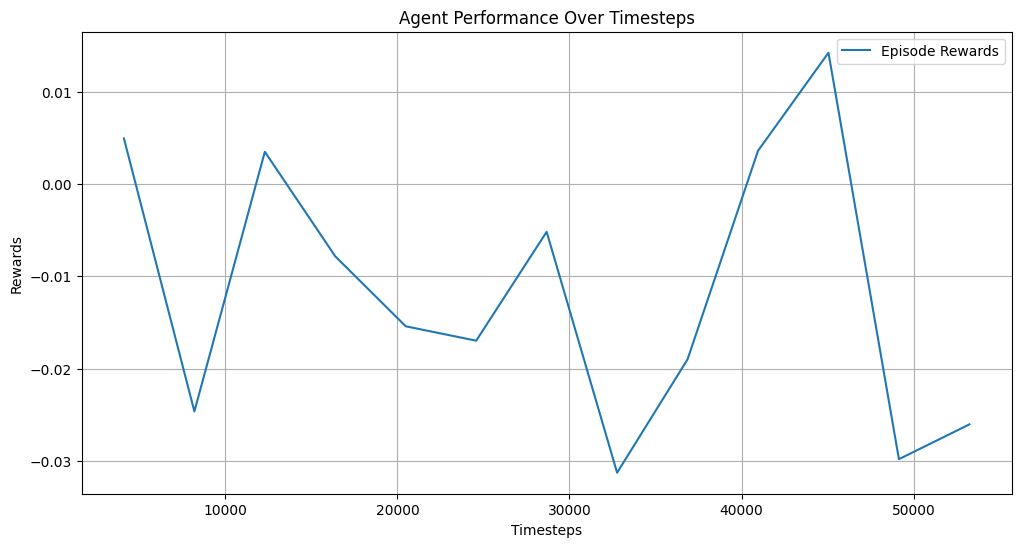

In [93]:
results, models = curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=50_000)

In [ ]:
results, models = curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=300_000)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe


Training on easy difficulty (With Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.


[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.22e+03 |
|    ep_rew_mean     | 11.2     |
| time/              |          |
|    fps             | 170      |
|    iterations      | 1        |
|    time_elapsed    | 24       |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.22e+03    |
|    ep_rew_mean          | 11.2        |
| time/                   |             |
|    fps                  | 172         |
|    iterations           | 2           |
|    time_elapsed         | 47          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012461651 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | -0.00684    |
|    learning_rate        | 0.

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.2e+03     |
|    ep_rew_mean          | 18.6        |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 3           |
|    time_elapsed         | 75          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.022162642 |
|    clip_fraction        | 0.283       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | 0.115       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0622     |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0338     |
|    std                  | 0.957       |
|    value_loss           | 0.0229      |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 925         |
|    ep_rew_mean          | 15.7        |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 4           |
|    time_elapsed         | 101         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.009357832 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.74       |
|    explained_variance   | 0.0183      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.428       |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00557    |
|    std                  | 0.947       |
|    value_loss           | 0.562       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 886         |
|    ep_rew_mean          | 18.8        |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 5           |
|    time_elapsed         | 128         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.013314581 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.72       |
|    explained_variance   | 0.071       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.176       |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00866    |
|    std                  | 0.939       |
|    value_loss           | 0.568       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 752         |
|    ep_rew_mean          | 19.1        |
| time/                   |             |
|    fps                  | 154         |
|    iterations           | 6           |
|    time_elapsed         | 158         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.011550697 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.67       |
|    explained_variance   | 0.259       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.129       |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00834    |
|    std                  | 0.907       |
|    value_loss           | 0.669       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 617         |
|    ep_rew_mean          | 18.6        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 7           |
|    time_elapsed         | 190         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.011291711 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.61       |
|    explained_variance   | 0.196       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.568       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00892    |
|    std                  | 0.883       |
|    value_loss           | 1.11        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 474          |
|    ep_rew_mean          | 17.2         |
| time/                   |              |
|    fps                  | 144          |
|    iterations           | 8            |
|    time_elapsed         | 226          |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0053922166 |
|    clip_fraction        | 0.0531       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.56        |
|    explained_variance   | 0.367        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.48         |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.00236     |
|    std                  | 0.866        |
|    value_loss           | 1.21         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 405         |
|    ep_rew_mean          | 17.7        |
| time/                   |             |
|    fps                  | 141         |
|    iterations           | 9           |
|    time_elapsed         | 260         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.008612732 |
|    clip_fraction        | 0.0626      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.53       |
|    explained_variance   | 0.533       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.12        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00326    |
|    std                  | 0.854       |
|    value_loss           | 1.64        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 188         |
|    ep_rew_mean          | 15.2        |
| time/                   |             |
|    fps                  | 136         |
|    iterations           | 10          |
|    time_elapsed         | 300         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.003879783 |
|    clip_fraction        | 0.049       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.5        |
|    explained_variance   | 0.469       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.71        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00202    |
|    std                  | 0.839       |
|    value_loss           | 2.52        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 131         |
|    ep_rew_mean          | 13.5        |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 11          |
|    time_elapsed         | 339         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.007826832 |
|    clip_fraction        | 0.0729      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.47       |
|    explained_variance   | 0.727       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.96        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00476    |
|    std                  | 0.832       |
|    value_loss           | 2.6         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 112          |
|    ep_rew_mean          | 11.9         |
| time/                   |              |
|    fps                  | 130          |
|    iterations           | 12           |
|    time_elapsed         | 376          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0060200756 |
|    clip_fraction        | 0.0576       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.45        |
|    explained_variance   | 0.285        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.93         |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00447     |
|    std                  | 0.825        |
|    value_loss           | 6.92         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 121         |
|    ep_rew_mean          | 14.5        |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 13          |
|    time_elapsed         | 415         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.007985283 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.44       |
|    explained_variance   | 0.6         |
|    learning_rate        | 0.0003      |
|    loss                 | 2.5         |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00771    |
|    std                  | 0.816       |
|    value_loss           | 4.59        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 122          |
|    ep_rew_mean          | 16.8         |
| time/                   |              |
|    fps                  | 126          |
|    iterations           | 14           |
|    time_elapsed         | 454          |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0076793563 |
|    clip_fraction        | 0.114        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.42        |
|    explained_variance   | 0.577        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.55         |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.00409     |
|    std                  | 0.807        |
|    value_loss           | 5.42         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | 19.5         |
| time/                   |              |
|    fps                  | 124          |
|    iterations           | 15           |
|    time_elapsed         | 494          |
|    total_timesteps      | 61440        |
| train/                  |              |
|    approx_kl            | 0.0066564027 |
|    clip_fraction        | 0.116        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.38        |
|    explained_variance   | 0.673        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.04         |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00316     |
|    std                  | 0.79         |
|    value_loss           | 6.27         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 110         |
|    ep_rew_mean          | 17.3        |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 16          |
|    time_elapsed         | 534         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.012567091 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.36       |
|    explained_variance   | 0.494       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.64        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.000296   |
|    std                  | 0.787       |
|    value_loss           | 5.85        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 22          |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 17          |
|    time_elapsed         | 570         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.014649585 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.34       |
|    explained_variance   | 0.506       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.19        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0118     |
|    std                  | 0.774       |
|    value_loss           | 9.03        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 137         |
|    ep_rew_mean          | 27.8        |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 18          |
|    time_elapsed         | 609         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.010577574 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.3        |
|    explained_variance   | 0.493       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.27        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00245    |
|    std                  | 0.761       |
|    value_loss           | 7.45        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 159          |
|    ep_rew_mean          | 37           |
| time/                   |              |
|    fps                  | 120          |
|    iterations           | 19           |
|    time_elapsed         | 643          |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0082939975 |
|    clip_fraction        | 0.133        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.27        |
|    explained_variance   | 0.515        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.12         |
|    n_updates            | 180          |
|    policy_gradient_loss | -0.000345    |
|    std                  | 0.751        |
|    value_loss           | 10.6         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 187         |
|    ep_rew_mean          | 50.5        |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 20          |
|    time_elapsed         | 676         |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.014030952 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.24       |
|    explained_variance   | 0.307       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.4        |
|    n_updates            | 190         |
|    policy_gradient_loss | 0.00488     |
|    std                  | 0.729       |
|    value_loss           | 11.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 205         |
|    ep_rew_mean          | 60          |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 21          |
|    time_elapsed         | 712         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.016110547 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.18       |
|    explained_variance   | -0.00789    |
|    learning_rate        | 0.0003      |
|    loss                 | 7.66        |
|    n_updates            | 200         |
|    policy_gradient_loss | 0.00432     |
|    std                  | 0.716       |
|    value_loss           | 13.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 217         |
|    ep_rew_mean          | 69.7        |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 22          |
|    time_elapsed         | 749         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.012513582 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.15       |
|    explained_variance   | 0.131       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.5        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00616    |
|    std                  | 0.708       |
|    value_loss           | 23.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 234         |
|    ep_rew_mean          | 83.6        |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 23          |
|    time_elapsed         | 781         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.008721378 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.14       |
|    explained_variance   | 0.263       |
|    learning_rate        | 0.0003      |
|    loss                 | 12          |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00203    |
|    std                  | 0.7         |
|    value_loss           | 22.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 246         |
|    ep_rew_mean          | 94.8        |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 24          |
|    time_elapsed         | 817         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.014126898 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.1        |
|    explained_variance   | 0.209       |
|    learning_rate        | 0.0003      |
|    loss                 | 13          |
|    n_updates            | 230         |
|    policy_gradient_loss | 0.00144     |
|    std                  | 0.686       |
|    value_loss           | 21.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 250         |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 25          |
|    time_elapsed         | 851         |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.008134788 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | 0.237       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.1        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00226    |
|    std                  | 0.679       |
|    value_loss           | 28.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 257         |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 26          |
|    time_elapsed         | 885         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.010995487 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.05       |
|    explained_variance   | 0.16        |
|    learning_rate        | 0.0003      |
|    loss                 | 10.5        |
|    n_updates            | 250         |
|    policy_gradient_loss | 0.00932     |
|    std                  | 0.669       |
|    value_loss           | 22.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 266         |
|    ep_rew_mean          | 131         |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 27          |
|    time_elapsed         | 920         |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.008718172 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2          |
|    explained_variance   | 0.249       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.7        |
|    n_updates            | 260         |
|    policy_gradient_loss | 0.011       |
|    std                  | 0.65        |
|    value_loss           | 24.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 279          |
|    ep_rew_mean          | 146          |
| time/                   |              |
|    fps                  | 119          |
|    iterations           | 28           |
|    time_elapsed         | 957          |
|    total_timesteps      | 114688       |
| train/                  |              |
|    approx_kl            | 0.0124075115 |
|    clip_fraction        | 0.196        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.96        |
|    explained_variance   | 0.198        |
|    learning_rate        | 0.0003       |
|    loss                 | 21           |
|    n_updates            | 270          |
|    policy_gradient_loss | 0.017        |
|    std                  | 0.64         |
|    value_loss           | 36.7         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 266         |
|    ep_rew_mean          | 147         |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 29          |
|    time_elapsed         | 994         |
|    total_timesteps      | 118784      |
| train/                  |             |
|    approx_kl            | 0.010253783 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | 0.168       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.1        |
|    n_updates            | 280         |
|    policy_gradient_loss | 0.00659     |
|    std                  | 0.637       |
|    value_loss           | 42.7        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 262         |
|    ep_rew_mean          | 153         |
| time/                   |             |
|    fps                  | 119         |
|    iterations           | 30          |
|    time_elapsed         | 1031        |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.007606264 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.92       |
|    explained_variance   | 0.344       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.8        |
|    n_updates            | 290         |
|    policy_gradient_loss | 0.000152    |
|    std                  | 0.629       |
|    value_loss           | 66.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 248         |
|    ep_rew_mean          | 152         |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 31          |
|    time_elapsed         | 1070        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.013025165 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.9        |
|    explained_variance   | 0.28        |
|    learning_rate        | 0.0003      |
|    loss                 | 30.7        |
|    n_updates            | 300         |
|    policy_gradient_loss | 0.00286     |
|    std                  | 0.625       |
|    value_loss           | 68.1        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 243          |
|    ep_rew_mean          | 155          |
| time/                   |              |
|    fps                  | 118          |
|    iterations           | 32           |
|    time_elapsed         | 1103         |
|    total_timesteps      | 131072       |
| train/                  |              |
|    approx_kl            | 0.0089555755 |
|    clip_fraction        | 0.184        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.88        |
|    explained_variance   | 0.225        |
|    learning_rate        | 0.0003       |
|    loss                 | 18.6         |
|    n_updates            | 310          |
|    policy_gradient_loss | 0.00722      |
|    std                  | 0.617        |
|    value_loss           | 59.3         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 227          |
|    ep_rew_mean          | 146          |
| time/                   |              |
|    fps                  | 118          |
|    iterations           | 33           |
|    time_elapsed         | 1142         |
|    total_timesteps      | 135168       |
| train/                  |              |
|    approx_kl            | 0.0149749145 |
|    clip_fraction        | 0.234        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.87        |
|    explained_variance   | 0.34         |
|    learning_rate        | 0.0003       |
|    loss                 | 15.2         |
|    n_updates            | 320          |
|    policy_gradient_loss | 0.0161       |
|    std                  | 0.616        |
|    value_loss           | 36.1         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 220         |
|    ep_rew_mean          | 147         |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 34          |
|    time_elapsed         | 1179        |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.007487707 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.86       |
|    explained_variance   | 0.137       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.2        |
|    n_updates            | 330         |
|    policy_gradient_loss | 0.00744     |
|    std                  | 0.614       |
|    value_loss           | 76.8        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 209         |
|    ep_rew_mean          | 138         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 35          |
|    time_elapsed         | 1218        |
|    total_timesteps      | 143360      |
| train/                  |             |
|    approx_kl            | 0.011148237 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.86       |
|    explained_variance   | 0.281       |
|    learning_rate        | 0.0003      |
|    loss                 | 29.2        |
|    n_updates            | 340         |
|    policy_gradient_loss | 0.00524     |
|    std                  | 0.614       |
|    value_loss           | 92.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 211         |
|    ep_rew_mean          | 145         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 36          |
|    time_elapsed         | 1254        |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.009103455 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.85       |
|    explained_variance   | 0.371       |
|    learning_rate        | 0.0003      |
|    loss                 | 55.1        |
|    n_updates            | 350         |
|    policy_gradient_loss | 0.00153     |
|    std                  | 0.609       |
|    value_loss           | 97.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 190         |
|    ep_rew_mean          | 127         |
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 37          |
|    time_elapsed         | 1292        |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.013730349 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.83       |
|    explained_variance   | 0.42        |
|    learning_rate        | 0.0003      |
|    loss                 | 29.3        |
|    n_updates            | 360         |
|    policy_gradient_loss | 0.00434     |
|    std                  | 0.604       |
|    value_loss           | 58.2        |
-----------------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on easy difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 263  |
|    iterations      | 1    |
|    time_elapsed    | 15   |
|    total_timesteps | 4096 |
-----------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.82e+03   |
|    ep_rew_mean          | 23.6       |
| time/                   |            |
|    fps                  | 221        |
|    iterations           | 2          |
|    time_elapsed         | 37         |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.01769419 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.81      |
|    explained_variance   | -0.105     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0462    |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0249    |
|    std                  | 0.975      |
|    value_loss           | 0.0139     |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.49e+03    |
|    ep_rew_mean          | 21.7        |
| time/                   |             |
|    fps                  | 216         |
|    iterations           | 3           |
|    time_elapsed         | 56          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.009692435 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | 0.00451     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.203       |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0112     |
|    std                  | 0.963       |
|    value_loss           | 0.241       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | 18.3        |
| time/                   |             |
|    fps                  | 205         |
|    iterations           | 4           |
|    time_elapsed         | 79          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.016603786 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.73       |
|    explained_variance   | 0.00914     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0268      |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0129     |
|    std                  | 0.943       |
|    value_loss           | 0.219       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 841         |
|    ep_rew_mean          | 17          |
| time/                   |             |
|    fps                  | 195         |
|    iterations           | 5           |
|    time_elapsed         | 104         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.008362964 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.7        |
|    explained_variance   | -0.00573    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0822      |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00521    |
|    std                  | 0.923       |
|    value_loss           | 0.57        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 762          |
|    ep_rew_mean          | 17.4         |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 6            |
|    time_elapsed         | 127          |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0039310735 |
|    clip_fraction        | 0.08         |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.67        |
|    explained_variance   | -0.039       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.443        |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00433     |
|    std                  | 0.919        |
|    value_loss           | 0.676        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 665         |
|    ep_rew_mean          | 17.3        |
| time/                   |             |
|    fps                  | 187         |
|    iterations           | 7           |
|    time_elapsed         | 153         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.009381418 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.65       |
|    explained_variance   | 0.339       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.258       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00542    |
|    std                  | 0.907       |
|    value_loss           | 0.482       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 553         |
|    ep_rew_mean          | 16.8        |
| time/                   |             |
|    fps                  | 182         |
|    iterations           | 8           |
|    time_elapsed         | 179         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.010961149 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | 0.441       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.333       |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00707    |
|    std                  | 0.893       |
|    value_loss           | 0.875       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 491          |
|    ep_rew_mean          | 17.4         |
| time/                   |              |
|    fps                  | 176          |
|    iterations           | 9            |
|    time_elapsed         | 208          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0066414676 |
|    clip_fraction        | 0.0654       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.59        |
|    explained_variance   | 0.559        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.782        |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00391     |
|    std                  | 0.885        |
|    value_loss           | 1.39         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 417         |
|    ep_rew_mean          | 17.1        |
| time/                   |             |
|    fps                  | 171         |
|    iterations           | 10          |
|    time_elapsed         | 239         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.008721327 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.55       |
|    explained_variance   | 0.776       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.224       |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00964    |
|    std                  | 0.867       |
|    value_loss           | 0.891       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 225         |
|    ep_rew_mean          | 15.6        |
| time/                   |             |
|    fps                  | 168         |
|    iterations           | 11          |
|    time_elapsed         | 267         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.008741021 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.53       |
|    explained_variance   | 0.759       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.555       |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00874    |
|    std                  | 0.855       |
|    value_loss           | 1.87        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 165         |
|    ep_rew_mean          | 15          |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 12          |
|    time_elapsed         | 302         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.007750921 |
|    clip_fraction        | 0.0802      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.5        |
|    explained_variance   | 0.305       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.5         |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00249    |
|    std                  | 0.846       |
|    value_loss           | 4.52        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 148         |
|    ep_rew_mean          | 15.6        |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 13          |
|    time_elapsed         | 332         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.007465809 |
|    clip_fraction        | 0.0952      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.48       |
|    explained_variance   | 0.768       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.856       |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0084     |
|    std                  | 0.839       |
|    value_loss           | 2.6         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 152          |
|    ep_rew_mean          | 18.8         |
| time/                   |              |
|    fps                  | 158          |
|    iterations           | 14           |
|    time_elapsed         | 362          |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0066142483 |
|    clip_fraction        | 0.0852       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.46        |
|    explained_variance   | 0.526        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.75         |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.00277     |
|    std                  | 0.825        |
|    value_loss           | 4.85         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 143         |
|    ep_rew_mean          | 19.7        |
| time/                   |             |
|    fps                  | 155         |
|    iterations           | 15          |
|    time_elapsed         | 394         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.010216158 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.43       |
|    explained_variance   | 0.575       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.59        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00405    |
|    std                  | 0.818       |
|    value_loss           | 5.3         |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 166         |
|    ep_rew_mean          | 26.1        |
| time/                   |             |
|    fps                  | 155         |
|    iterations           | 16          |
|    time_elapsed         | 422         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.021936383 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.41       |
|    explained_variance   | 0.543       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.83        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00865    |
|    std                  | 0.809       |
|    value_loss           | 7.08        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 183         |
|    ep_rew_mean          | 33.6        |
| time/                   |             |
|    fps                  | 154         |
|    iterations           | 17          |
|    time_elapsed         | 451         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.011500937 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.36       |
|    explained_variance   | 0.433       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.05        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00689    |
|    std                  | 0.779       |
|    value_loss           | 6.35        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 193         |
|    ep_rew_mean          | 40          |
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 18          |
|    time_elapsed         | 480         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.012077523 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.3        |
|    explained_variance   | 0.246       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.41        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00403    |
|    std                  | 0.757       |
|    value_loss           | 8.39        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 213         |
|    ep_rew_mean          | 50          |
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 19          |
|    time_elapsed         | 507         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.011809058 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.25       |
|    explained_variance   | 0.269       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.37        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00187    |
|    std                  | 0.743       |
|    value_loss           | 8.56        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 224        |
|    ep_rew_mean          | 59.9       |
| time/                   |            |
|    fps                  | 151        |
|    iterations           | 20         |
|    time_elapsed         | 540        |
|    total_timesteps      | 81920      |
| train/                  |            |
|    approx_kl            | 0.01691952 |
|    clip_fraction        | 0.182      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.22      |
|    explained_variance   | 0.168      |
|    learning_rate        | 0.0003     |
|    loss                 | 5.58       |
|    n_updates            | 190        |
|    policy_gradient_loss | 0.00201    |
|    std                  | 0.727      |
|    value_loss           | 13.7       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 246        |
|    ep_rew_mean          | 73.9       |
| time/                   |            |
|    fps                  | 151        |
|    iterations           | 21         |
|    time_elapsed         | 569        |
|    total_timesteps      | 86016      |
| train/                  |            |
|    approx_kl            | 0.01612052 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.18      |
|    explained_variance   | 0.355      |
|    learning_rate        | 0.0003     |
|    loss                 | 5.22       |
|    n_updates            | 200        |
|    policy_gradient_loss | -0.0118    |
|    std                  | 0.719      |
|    value_loss           | 19.9       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 237         |
|    ep_rew_mean          | 80.7        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 22          |
|    time_elapsed         | 599         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.018758914 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.16       |
|    explained_variance   | 0.277       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.82        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00466    |
|    std                  | 0.712       |
|    value_loss           | 21.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 230        |
|    ep_rew_mean          | 87.2       |
| time/                   |            |
|    fps                  | 149        |
|    iterations           | 23         |
|    time_elapsed         | 628        |
|    total_timesteps      | 94208      |
| train/                  |            |
|    approx_kl            | 0.02109794 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.14      |
|    explained_variance   | 0.299      |
|    learning_rate        | 0.0003     |
|    loss                 | 9.7        |
|    n_updates            | 220        |
|    policy_gradient_loss | -0.0044    |
|    std                  | 0.701      |
|    value_loss           | 28.3       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 208         |
|    ep_rew_mean          | 87.5        |
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 24          |
|    time_elapsed         | 661         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.029321933 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.1        |
|    explained_variance   | 0.0182      |
|    learning_rate        | 0.0003      |
|    loss                 | 9.51        |
|    n_updates            | 230         |
|    policy_gradient_loss | 0.00551     |
|    std                  | 0.688       |
|    value_loss           | 32.5        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80.1        |
|    ep_rew_mean          | 25.2        |
| time/                   |             |
|    fps                  | 147         |
|    iterations           | 25          |
|    time_elapsed         | 695         |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.013764953 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.08       |
|    explained_variance   | 0.258       |
|    learning_rate        | 0.0003      |
|    loss                 | 27.7        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00105    |
|    std                  | 0.679       |
|    value_loss           | 40.9        |
-----------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 578      |
|    ep_rew_mean     | 2.97     |
| time/              |          |
|    fps             | 132      |
|    iterations      | 1        |
|    time_elapsed    | 30       |
|    total_timesteps | 4096     |
---------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.47e+03    |
|    ep_rew_mean          | 15.6        |
| time/                   |             |
|    fps                  | 139         |
|    iterations           | 2           |
|    time_elapsed         | 58          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012125524 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | 0.00722     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0628      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00588    |
|    std                  | 0.991       |
|    value_loss           | 0.254       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.15e+03    |
|    ep_rew_mean          | 15.1        |
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 3           |
|    time_elapsed         | 94          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.013328221 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.0236      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00172    |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0132     |
|    std                  | 0.977       |
|    value_loss           | 0.184       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_mean          | 17.1        |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 4           |
|    time_elapsed         | 128         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.011124082 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.79       |
|    explained_variance   | 0.00086     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.184       |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00544    |
|    std                  | 0.976       |
|    value_loss           | 0.439       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 20.6       |
| time/                   |            |
|    fps                  | 125        |
|    iterations           | 5          |
|    time_elapsed         | 163        |
|    total_timesteps      | 20480      |
| train/                  |            |
|    approx_kl            | 0.01171529 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.77      |
|    explained_variance   | 0.00489    |
|    learning_rate        | 0.0003     |
|    loss                 | 0.148      |
|    n_updates            | 40         |
|    policy_gradient_loss | -0.00651   |
|    std                  | 0.956      |
|    value_loss           | 0.563      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 891         |
|    ep_rew_mean          | 22.1        |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 6           |
|    time_elapsed         | 207         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.012571793 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.73       |
|    explained_variance   | 0.0549      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0848      |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.011      |
|    std                  | 0.948       |
|    value_loss           | 0.446       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 677         |
|    ep_rew_mean          | 19.6        |
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 7           |
|    time_elapsed         | 263         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.010625262 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.69       |
|    explained_variance   | -0.0686     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.493       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00829    |
|    std                  | 0.923       |
|    value_loss           | 0.825       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 481         |
|    ep_rew_mean          | 16.1        |
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 8           |
|    time_elapsed         | 333         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.008892284 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.65       |
|    explained_variance   | 0.151       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.52        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00635    |
|    std                  | 0.908       |
|    value_loss           | 1.75        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 376          |
|    ep_rew_mean          | 14.3         |
| time/                   |              |
|    fps                  | 89           |
|    iterations           | 9            |
|    time_elapsed         | 410          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0062948046 |
|    clip_fraction        | 0.0471       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.62        |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.73         |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00236     |
|    std                  | 0.893        |
|    value_loss           | 2.75         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 183         |
|    ep_rew_mean          | 12.3        |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 10          |
|    time_elapsed         | 479         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.008286314 |
|    clip_fraction        | 0.0679      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.59       |
|    explained_variance   | 0.535       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.911       |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00385    |
|    std                  | 0.884       |
|    value_loss           | 2.45        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 138         |
|    ep_rew_mean          | 11.9        |
| time/                   |             |
|    fps                  | 81          |
|    iterations           | 11          |
|    time_elapsed         | 550         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.005669968 |
|    clip_fraction        | 0.052       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.57       |
|    explained_variance   | 0.508       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.38        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00453    |
|    std                  | 0.871       |
|    value_loss           | 3.45        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 153          |
|    ep_rew_mean          | 15.8         |
| time/                   |              |
|    fps                  | 78           |
|    iterations           | 12           |
|    time_elapsed         | 629          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0073576085 |
|    clip_fraction        | 0.104        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.54        |
|    explained_variance   | 0.324        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.24         |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00221     |
|    std                  | 0.862        |
|    value_loss           | 5.05         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 135         |
|    ep_rew_mean          | 16.5        |
| time/                   |             |
|    fps                  | 73          |
|    iterations           | 13          |
|    time_elapsed         | 721         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.009688275 |
|    clip_fraction        | 0.062       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.51       |
|    explained_variance   | 0.413       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.78        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00255    |
|    std                  | 0.847       |
|    value_loss           | 3.93        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 131         |
|    ep_rew_mean          | 18.6        |
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 14          |
|    time_elapsed         | 809         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.007833973 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.49       |
|    explained_variance   | 0.386       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.41        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00533    |
|    std                  | 0.842       |
|    value_loss           | 6.97        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 107        |
|    ep_rew_mean          | 15.6       |
| time/                   |            |
|    fps                  | 68         |
|    iterations           | 15         |
|    time_elapsed         | 901        |
|    total_timesteps      | 61440      |
| train/                  |            |
|    approx_kl            | 0.00977307 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.47      |
|    explained_variance   | 0.519      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.91       |
|    n_updates            | 140        |
|    policy_gradient_loss | -0.00684   |
|    std                  | 0.829      |
|    value_loss           | 7.52       |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 97.4        |
|    ep_rew_mean          | 13.9        |
| time/                   |             |
|    fps                  | 66          |
|    iterations           | 16          |
|    time_elapsed         | 990         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.009552766 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.45       |
|    explained_variance   | 0.597       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.8         |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00929    |
|    std                  | 0.824       |
|    value_loss           | 7.45        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 107         |
|    ep_rew_mean          | 16.7        |
| time/                   |             |
|    fps                  | 64          |
|    iterations           | 17          |
|    time_elapsed         | 1079        |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.012308994 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.43       |
|    explained_variance   | 0.479       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.51        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0111     |
|    std                  | 0.813       |
|    value_loss           | 9.12        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 114         |
|    ep_rew_mean          | 20.3        |
| time/                   |             |
|    fps                  | 62          |
|    iterations           | 18          |
|    time_elapsed         | 1173        |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.010895958 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.39       |
|    explained_variance   | 0.488       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.28        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00791    |
|    std                  | 0.792       |
|    value_loss           | 9.98        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 133         |
|    ep_rew_mean          | 28          |
| time/                   |             |
|    fps                  | 61          |
|    iterations           | 19          |
|    time_elapsed         | 1259        |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.027370358 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.34       |
|    explained_variance   | 0.465       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.41        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00512    |
|    std                  | 0.776       |
|    value_loss           | 12.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 153         |
|    ep_rew_mean          | 37.7        |
| time/                   |             |
|    fps                  | 60          |
|    iterations           | 20          |
|    time_elapsed         | 1348        |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.008845311 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.29       |
|    explained_variance   | 0.385       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.04        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00316    |
|    std                  | 0.749       |
|    value_loss           | 15.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 159         |
|    ep_rew_mean          | 44.9        |
| time/                   |             |
|    fps                  | 59          |
|    iterations           | 21          |
|    time_elapsed         | 1438        |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.038919285 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.22       |
|    explained_variance   | 0.327       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.53        |
|    n_updates            | 200         |
|    policy_gradient_loss | -4.38e-06   |
|    std                  | 0.728       |
|    value_loss           | 14.9        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 133         |
|    ep_rew_mean          | 38.2        |
| time/                   |             |
|    fps                  | 58          |
|    iterations           | 22          |
|    time_elapsed         | 1532        |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.029612206 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.19       |
|    explained_variance   | 0.274       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.5        |
|    n_updates            | 210         |
|    policy_gradient_loss | 0.00613     |
|    std                  | 0.719       |
|    value_loss           | 22.3        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 120         |
|    ep_rew_mean          | 35.6        |
| time/                   |             |
|    fps                  | 58          |
|    iterations           | 23          |
|    time_elapsed         | 1623        |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.014756215 |
|    clip_fraction        | 0.263       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.17       |
|    explained_variance   | 0.387       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.8        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00849    |
|    std                  | 0.719       |
|    value_loss           | 28.2        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.
[INFO] Episode ended! Sc

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 132         |
|    ep_rew_mean          | 42.7        |
| time/                   |             |
|    fps                  | 57          |
|    iterations           | 24          |
|    time_elapsed         | 1701        |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.015549764 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.16       |
|    explained_variance   | 0.178       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.7        |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00884    |
|    std                  | 0.705       |
|    value_loss           | 25.6        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Sc

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 152        |
|    ep_rew_mean          | 53.7       |
| time/                   |            |
|    fps                  | 57         |
|    iterations           | 25         |
|    time_elapsed         | 1779       |
|    total_timesteps      | 102400     |
| train/                  |            |
|    approx_kl            | 0.03137482 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.11      |
|    explained_variance   | 0.174      |
|    learning_rate        | 0.0003     |
|    loss                 | 9.31       |
|    n_updates            | 240        |
|    policy_gradient_loss | 0.0061     |
|    std                  | 0.688      |
|    value_loss           | 15.2       |
----------------------------------------
Performance for easy difficulty:


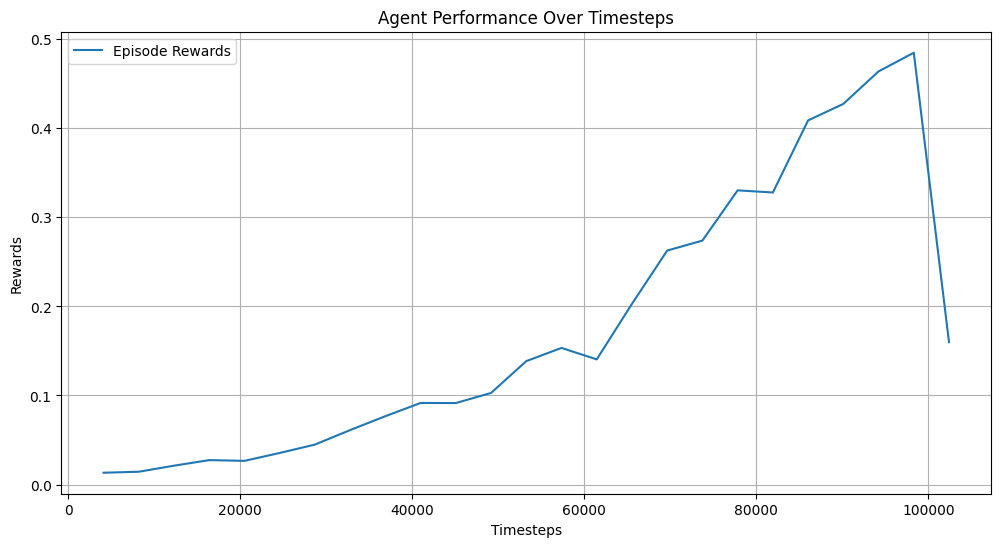

Performance for medium difficulty:


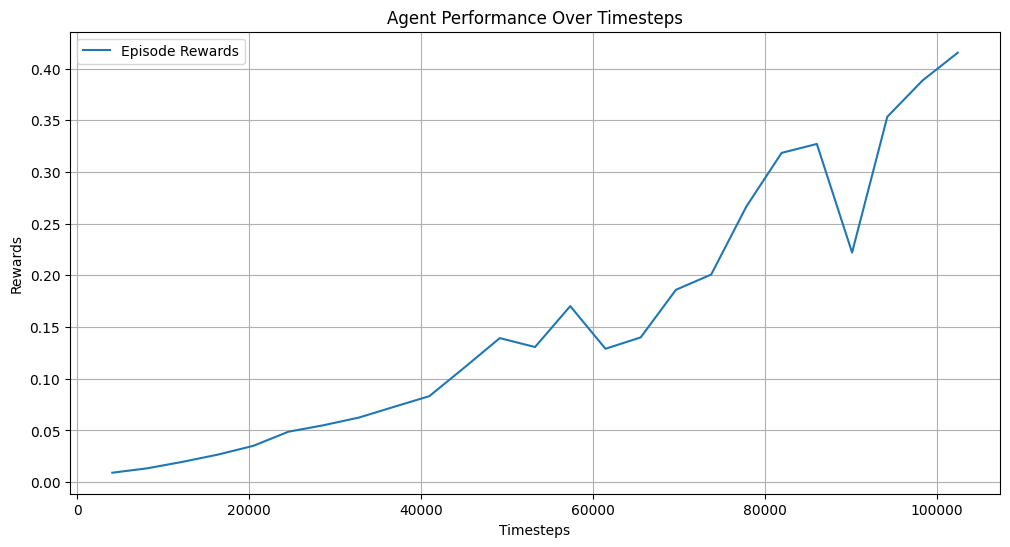

In [105]:
results, models = curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=200_000)

In [109]:
difficulty_order

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['easy', 'medium']

In [95]:
models

[('easy', <stable_baselines3.ppo.ppo.PPO at 0x7c5e9ee93730>),
 ('medium', <stable_baselines3.ppo.ppo.PPO at 0x7c5ea2fad870>)]

In [116]:
model = models[1][1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


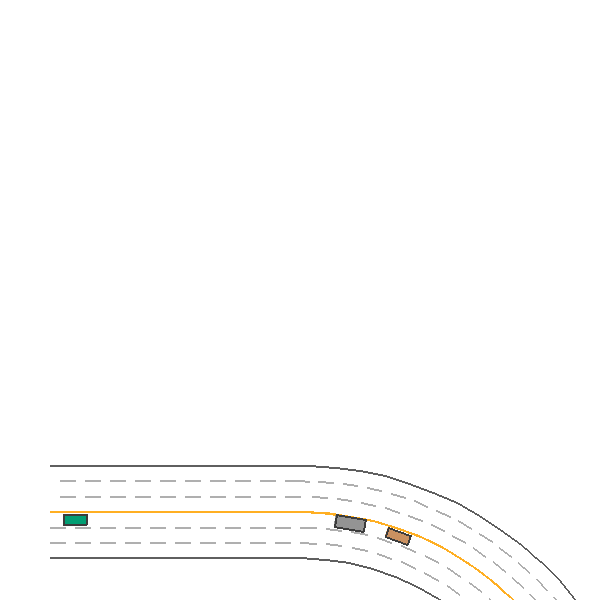

In [117]:
env = create_environment('medium', render=False, monitor=False)
obs, _ = env.reset()
try:
    for i in range(1_000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()
# prompt: load demo.gif and display it

from IPython.display import Image

Image(filename='demo.gif')

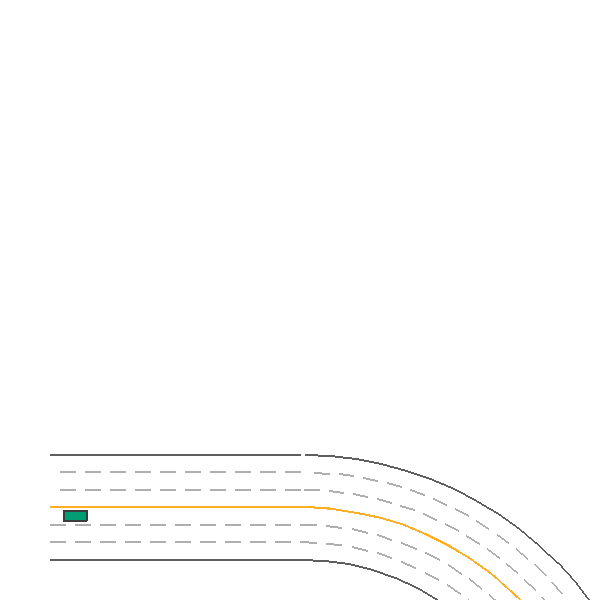

In [113]:
# prompt: load demo.gif and display it

from IPython.display import Image

Image(filename='demo.gif')

In [ ]:
# prompt: load demo.dif and display it

import os
import numpy as np
from stable_baselines3 import PPO
from metadrive.envs import MetaDriveEnv
from pyvirtualdisplay import Display
from PIL import Image
from IPython.display import display as ipy_display, clear_output
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
# %pip install git+https://github.com/metadriverse/metadrive.git
# !pip install stable-baselines3  # For PPO experiments
# !pip install gym  # Ensure gym is installed

# !apt-get install -y xvfb python-opengl ffmpeg

# !pip install pyvirtualdisplay

# !sudo apt-get update
# !sudo apt-get install -y xvfb

class PerformanceLogger(BaseCallback):
    def __init__(self, verbose=0):
        super(PerformanceLogger, self).__init__(verbose)
        self.timesteps = []
        self.rewards = []
        self.current_reward = 0

    def reset(self):
        """Reset the logger for a new training phase."""
        self.current_reward = 0


    def _on_step(self) -> bool:
        # Sum rewards from this step
        self.current_reward += sum(self.locals["rewards"])

        # Log rewards at the end of a rollout
        if self.n_calls % self.model.n_steps == 0:
            self.timesteps.append(self.num_timesteps)
            self.rewards.append(self.current_reward / self.model.n_steps)  # Average reward per step
            self.current_reward = 0  # Reset for next rollout
        return True

# Function to create the environment
def create_environment(difficulty, render=False, monitor=True):
    configs = {
        "easy": {"map": 3, "traffic_density": 0.1, "random_lane_width": False, "use_render": render},
        "medium": {"map": 5, "traffic_density": 0.3, "random_lane_width": True, "use_render": render},
        "hard": {"map": 7, "traffic_density": 0.5, "random_lane_width": True, "use_render": render},
    }

    base_env = MetaDriveEnv(configs[difficulty])
    if monitor:
        return Monitor(base_env)
    else:
      return base_env
def train_agent_with_transfer(env, timesteps=1000, model=None):
    logger = PerformanceLogger()
    if model is None:
        model = PPO("MlpPolicy", env, verbose=2, n_steps=32) #changing n_step param significantly changes reward results, should play ard with this
    else:
        print("Continuing training with transfer learning...")
    logger.reset()  # Reset logger for the new training phase
    model.learn(total_timesteps=timesteps, callback=logger)
    return model, logger
def plot_performance(logger, title= 'Agent Performance'):
    """
    Plot the logged performance data.
    """
    if not logger.timesteps or not logger.rewards:
        print("[ERROR] No data to plot. Ensure rewards are logged during training.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(logger.timesteps, logger.rewards, label="Episode Rewards")
    plt.xlabel("Timesteps")
    plt.ylabel("Rewards")
    plt.title("Agent Performance Over Timesteps")
    plt.legend()
    plt.grid()
    plt.show()
# Curriculum experiment without transfer learning
def curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=10000):
    results = []
    models = []
    for difficulty in difficulty_order:
        print(f"Training on {difficulty} difficulty (No Transfer)...")
        env = create_environment(difficulty, render=False)
        try:
            model, logger = train_agent_with_transfer(env, timesteps=timesteps_per_difficulty)
            results.append((difficulty, logger))
            models.append((difficulty, model))
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(logger, f"Performance on {difficulty} (No Transfer)")
    return results,  models
# Curriculum experiment with transfer learning
def curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=1000):
    model = None  # Start with no pretrained model
    logger = PerformanceLogger()
    results = []
    models = []

    for difficulty in difficulty_order:
        print(f"Training on {difficulty} difficulty (With Transfer)...")
        env = create_environment(difficulty, render=False)
        try:
            model, logger = train_agent_with_transfer(env, model=model, timesteps=timesteps_per_difficulty)
            results.append((difficulty, logger))
            models.append((difficulty, model))
        except Exception as e:
            print(f"Error during training on {difficulty} difficulty: {e}")
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(logger, f"Performance on {difficulty} (With Transfer)")
    return results, models
# Run the curriculum experiments
difficulty_order = ["easy", "medium", "hard"]

# Experiment without transfer learning
# print("Running Curriculum Experiment WITHOUT Transfer Learning...")
# curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=500)

# # Experiment with transfer learning
# print("Running Curriculum Experiment WITH Transfer Learning...")
# curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=500)
results, models = curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=1000)
model = models[2][1]
env = create_environment('medium', render=False, monitor=False)
obs, _ = env.reset()
try:
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()

In [ ]:
env = MetaDriveEnv( {"map": 3, "traffic_density": 0.1, "random_lane_width": False, "use_render": False})

e = Monitor(env)
dir(e)
e.render(mode="topdown",
                    window=False,
                    screen_size=(600, 600),
                    camera_position=(50, 50))

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None


TypeError: render() got an unexpected keyword argument 'mode'

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


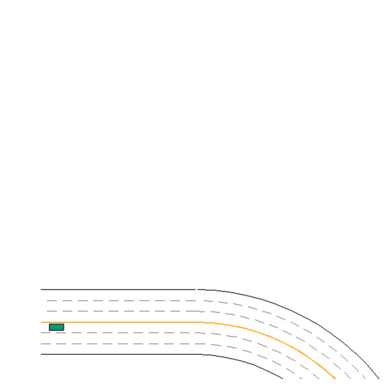

In [ ]:
try:
    env.close()
except:
    pass
total_reward = 0
env = MetaDriveEnv( {"map": 3, "traffic_density": 0.1, "random_lane_width": False, "use_render": False})
model = PPO("MlpPolicy",
            train_env,
            n_steps=4096,
            verbose=1)
try:
    e = Monitor(env)
    env = e.unwrapped
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()
plt.axis("off")
plt.imshow(ret)

In [ ]:
model

NameError: name 'model' is not defined

In [ ]:
from metadrive.envs import MetaDriveEnv
from metadrive.policy.lange_change_policy import LaneChangePolicy
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
from metadrive.component.map.base_map import BaseMap
from metadrive.utils import generate_gif
from IPython.display import Image

def create_env(need_monitor=False):
    env = MetaDriveEnv(dict(map="C",
                      # This policy setting simplifies the task
                      discrete_action=True,
                      discrete_throttle_dim=3,
                      discrete_steering_dim=3,
                      horizon=500,
                      # scenario setting
                      random_spawn_lane_index=False,
                      num_scenarios=1,
                      start_seed=5,
                      traffic_density=0,
                      accident_prob=0,
                      log_level=50))
    if need_monitor:
        env = Monitor(env)
    return env

In [ ]:
env.close()

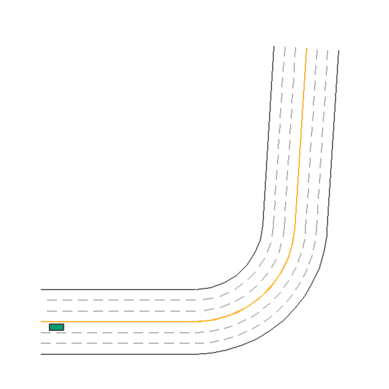

In [ ]:
env=create_env()
env.reset()
ret = env.render(mode="topdown",
                 window=False,
                 screen_size=(600, 600),
                 camera_position=(50, 50))
env.close()
plt.axis("off")
plt.imshow(ret)

In [ ]:
timesteps_per_difficulty=1000
difficulty = "easy"
results = []
env = create_environment(difficulty, render=False)
try:
    model, logger = train_agent_with_transfer(env, timesteps=timesteps_per_difficulty)
    results.append((difficulty, logger))
    obs, _ = env.reset()
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()

In [ ]:
try:
    env.close()
except:
    pass
env = create_environment("easy", render=False)
try:
    env.reset()
    ret = env.render(
        mode="topdown",
                    window=False,
                    screen_size=(600, 600),
                    camera_position=(50, 50))
finally:
    env.close()
plt.axis("off")
plt.imshow(ret)

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3


Exception: Attempt to spawn multiple ShowBase instances!

In [ ]:
env = create_environment(difficulty, render=False)
obs, _ = env.reset()
try:
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3


Exception: Attempt to spawn multiple ShowBase instances!

: 

In [ ]:
timesteps_per_difficulty=1000
difficulty = "easy"
results = []
env = create_environment(difficulty, render=False)
try:
    model, logger = train_agent_with_transfer(env, timesteps=timesteps_per_difficulty)
    results.append((difficulty, logger))
    obs, _ = env.reset()
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 72 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.008032592 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.349      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00238    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0067     |
|    std                  | 1           |
|    value_loss           | 0.0184    

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 302        |
|    ep_rew_mean          | 4.28       |
| time/                   |            |
|    fps                  | 138        |
|    iterations           | 10         |
|    time_elapsed         | 2          |
|    total_timesteps      | 320        |
| train/                  |            |
|    approx_kl            | 0.00643057 |
|    clip_fraction        | 0.0156     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.85      |
|    explained_variance   | 0.018      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0637     |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.0171    |
|    std                  | 1          |
|    value_loss           | 0.423      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 168          |
|    ep_rew_mean          | 1.37         |
| time/                   |              |
|    fps                  | 137          |
|    iterations           | 11           |
|    time_elapsed         | 2            |
|    total_timesteps      | 352          |
| train/                  |              |
|    approx_kl            | 0.0039157253 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.014        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.66         |
|    n_updates            | 100          |
|    policy_gradient_loss | 0.000467     |
|    std                  | 1            |
|    value_loss           | 10.5         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 159          |
|    ep_rew_mean          | 5.33         |
| time/                   |              |
|    fps                  | 128          |
|    iterations           | 15           |
|    time_elapsed         | 3            |
|    total_timesteps      | 480          |
| train/                  |              |
|    approx_kl            | 0.0030155852 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -0.00127     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.365        |
|    n_updates            | 140          |
|    policy_gradient_loss | 0.0033       |
|    std                  | 1            |
|    value_loss           | 1.48         |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 138          |
|    ep_rew_mean          | 4.76         |
| time/                   |              |
|    fps                  | 128          |
|    iterations           | 18           |
|    time_elapsed         | 4            |
|    total_timesteps      | 576          |
| train/                  |              |
|    approx_kl            | 0.0034488663 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.0286       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0975       |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00735     |
|    std                  | 1            |
|    value_loss           | 0.394        |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 125          |
|    ep_rew_mean          | 5.35         |
| time/                   |              |
|    fps                  | 126          |
|    iterations           | 20           |
|    time_elapsed         | 5            |
|    total_timesteps      | 640          |
| train/                  |              |
|    approx_kl            | 0.0008909926 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.027        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.48         |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00226     |
|    std                  | 0.998        |
|    value_loss           | 3.33         |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 114          |
|    ep_rew_mean          | 5.81         |
| time/                   |              |
|    fps                  | 126          |
|    iterations           | 22           |
|    time_elapsed         | 5            |
|    total_timesteps      | 704          |
| train/                  |              |
|    approx_kl            | 0.0001265388 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.0323       |
|    learning_rate        | 0.0003       |
|    loss                 | 3.52         |
|    n_updates            | 210          |
|    policy_gradient_loss | 0.00123      |
|    std                  | 0.998        |
|    value_loss           | 7.49         |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 107          |
|    ep_rew_mean          | 5.96         |
| time/                   |              |
|    fps                  | 124          |
|    iterations           | 24           |
|    time_elapsed         | 6            |
|    total_timesteps      | 768          |
| train/                  |              |
|    approx_kl            | 5.484186e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.0395       |
|    learning_rate        | 0.0003       |
|    loss                 | 2.4          |
|    n_updates            | 230          |
|    policy_gradient_loss | 0.00127      |
|    std                  | 0.997        |
|    value_loss           | 5.14         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 104          |
|    ep_rew_mean          | 6.01         |
| time/                   |              |
|    fps                  | 124          |
|    iterations           | 26           |
|    time_elapsed         | 6            |
|    total_timesteps      | 832          |
| train/                  |              |
|    approx_kl            | 0.0036225468 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | -0.00138     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.483        |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.0129      |
|    std                  | 0.996        |
|    value_loss           | 1.18         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 94.9         |
|    ep_rew_mean          | 5.09         |
| time/                   |              |
|    fps                  | 124          |
|    iterations           | 27           |
|    time_elapsed         | 6            |
|    total_timesteps      | 864          |
| train/                  |              |
|    approx_kl            | 0.0045335162 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.00952      |
|    learning_rate        | 0.0003       |
|    loss                 | 5.1          |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00401     |
|    std                  | 0.995        |
|    value_loss           | 10.5         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 92.6         |
|    ep_rew_mean          | 5.17         |
| time/                   |              |
|    fps                  | 124          |
|    iterations           | 29           |
|    time_elapsed         | 7            |
|    total_timesteps      | 928          |
| train/                  |              |
|    approx_kl            | 0.0020335894 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.0086       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.09         |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.00786     |
|    std                  | 0.995        |
|    value_loss           | 2.35         |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 90.8          |
|    ep_rew_mean          | 5.42          |
| time/                   |               |
|    fps                  | 125           |
|    iterations           | 32            |
|    time_elapsed         | 8             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 1.1753291e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.83         |
|    explained_variance   | 0.016         |
|    learning_rate        | 0.0003        |
|    loss                 | 2.03          |
|    n_updates            | 310           |
|    policy_gradient_loss | 0.00171       |
|    std                  | 0.994         |
|    value_loss           | 4.92          |
-------------------------------------------


TypeError: render() got an unexpected keyword argument 'mode'

In [ ]:
Image(open("demo.gif", 'rb').read())

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Running Curriculum Experiment WITHOUT Transfer Learning...
Training on easy difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 85 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 122          |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 64           |
| train/                  |              |
|    approx_kl            | 0.0148714315 |
|    clip_fraction        | 0.0531       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -0.188       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0521      |
|    n_updates            | 10           |
|  

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 119          |
|    ep_rew_mean          | -2.39        |
| time/                   |              |
|    fps                  | 132          |
|    iterations           | 4            |
|    time_elapsed         | 0            |
|    total_timesteps      | 128          |
| train/                  |              |
|    approx_kl            | 0.0052361134 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.0162       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00911      |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.0128      |
|    std                  | 1            |
|    value_loss           | 0.0938       |
------------------------------------------
-----------------------------------------
| rollout/  

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 93           |
|    ep_rew_mean          | -1.88        |
| time/                   |              |
|    fps                  | 139          |
|    iterations           | 6            |
|    time_elapsed         | 1            |
|    total_timesteps      | 192          |
| train/                  |              |
|    approx_kl            | 0.0014298856 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.0149       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.197        |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00165     |
|    std                  | 1            |
|    value_loss           | 0.651        |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 89.3       |
|    ep_rew_mean          | -1.39      |
| time/                   |            |
|    fps                  | 149        |
|    iterations           | 9          |
|    time_elapsed         | 1          |
|    total_timesteps      | 288        |
| train/                  |            |
|    approx_kl            | 0.01488691 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.83      |
|    explained_variance   | 0.0141     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0282     |
|    n_updates            | 80         |
|    policy_gradient_loss | -0.011     |
|    std                  | 0.997      |
|    value_loss           | 0.132      |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 86.8          |
|    ep_rew_mean          | -1.56         |
| time/                   |               |
|    fps                  | 151           |
|    iterations           | 11            |
|    time_elapsed         | 2             |
|    total_timesteps      | 352           |
| train/                  |               |
|    approx_kl            | 0.00013663061 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.83         |
|    explained_variance   | -0.0243       |
|    learning_rate        | 0.0003        |
|    loss                 | 0.114         |
|    n_updates            | 100           |
|    policy_gradient_loss | 0.00204       |
|    std                  | 0.997         |
|    value_loss           | 0.31          |
-------------------------------------------
--------------------------------

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 82.4         |
|    ep_rew_mean          | -1.72        |
| time/                   |              |
|    fps                  | 150          |
|    iterations           | 13           |
|    time_elapsed         | 2            |
|    total_timesteps      | 416          |
| train/                  |              |
|    approx_kl            | 0.0034064613 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | -0.00214     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0628       |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00817     |
|    std                  | 0.999        |
|    value_loss           | 0.218        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 63.4         |
|    ep_rew_mean          | -2.39        |
| time/                   |              |
|    fps                  | 145          |
|    iterations           | 14           |
|    time_elapsed         | 3            |
|    total_timesteps      | 448          |
| train/                  |              |
|    approx_kl            | 0.0026339982 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.00171      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.54         |
|    n_updates            | 130          |
|    policy_gradient_loss | 0.00655      |
|    std                  | 1            |
|    value_loss           | 3.36         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 62.2         |
|    ep_rew_mean          | -2.25        |
| time/                   |              |
|    fps                  | 146          |
|    iterations           | 16           |
|    time_elapsed         | 3            |
|    total_timesteps      | 512          |
| train/                  |              |
|    approx_kl            | 0.0056114886 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.00232      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.112        |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00918     |
|    std                  | 1            |
|    value_loss           | 0.292        |
------------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 23 |
|    iterations      | 1  |
|    time_elapsed    | 1  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 36          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.007510271 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.528      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00742    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00721    |
|    std                  | 1    

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 272          |
|    ep_rew_mean          | 5.74         |
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 9            |
|    time_elapsed         | 5            |
|    total_timesteps      | 288          |
| train/                  |              |
|    approx_kl            | 0.0039082877 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | -0.0291      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.151        |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00623     |
|    std                  | 1.01         |
|    value_loss           | 0.845        |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 127          |
|    ep_rew_mean          | 2.25         |
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 12           |
|    time_elapsed         | 7            |
|    total_timesteps      | 384          |
| train/                  |              |
|    approx_kl            | 0.0019683018 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | 0.00483      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.211        |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00663     |
|    std                  | 1            |
|    value_loss           | 1.08         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 89.2        |
|    ep_rew_mean          | 0.348       |
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 14          |
|    time_elapsed         | 9           |
|    total_timesteps      | 448         |
| train/                  |             |
|    approx_kl            | 0.012951184 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.85       |
|    explained_variance   | 0.0506      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00423     |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0305     |
|    std                  | 1           |
|    value_loss           | 0.177       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 77           |
|    ep_rew_mean          | -0.327       |
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 15           |
|    time_elapsed         | 9            |
|    total_timesteps      | 480          |
| train/                  |              |
|    approx_kl            | 0.0053646453 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | -0.000731    |
|    learning_rate        | 0.0003       |
|    loss                 | 9.69         |
|    n_updates            | 140          |
|    policy_gradient_loss | 0.0163       |
|    std                  | 1            |
|    value_loss           | 20.5         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 63.9         |
|    ep_rew_mean          | -0.914       |
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 16           |
|    time_elapsed         | 10           |
|    total_timesteps      | 512          |
| train/                  |              |
|    approx_kl            | 0.0013963338 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | -0.000168    |
|    learning_rate        | 0.0003       |
|    loss                 | 4.77         |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00359     |
|    std                  | 1            |
|    value_loss           | 10.7         |
------------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on hard difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 12 |
|    iterations      | 1  |
|    time_elapsed    | 2  |
|    total_timesteps | 32 |
---------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 2          |
|    time_elapsed         | 3          |
|    total_timesteps      | 64         |
| train/                  |            |
|    approx_kl            | 0.00767746 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.84      |
|    explained_variance   | -0.193     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0201    |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0141    |
|    std                  | 1          |
|    value

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 311         |
|    ep_rew_mean          | 11.7        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 10          |
|    time_elapsed         | 15          |
|    total_timesteps      | 320         |
| train/                  |             |
|    approx_kl            | 0.010824438 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | -0.0422     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00215    |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00855    |
|    std                  | 0.998       |
|    value_loss           | 0.232       |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 218        |
|    ep_rew_mean          | 8.5        |
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 14         |
|    time_elapsed         | 21         |
|    total_timesteps      | 448        |
| train/                  |            |
|    approx_kl            | 0.01331882 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.83      |
|    explained_variance   | 0.0124     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0174    |
|    n_updates            | 130        |
|    policy_gradient_loss | -0.0132    |
|    std                  | 0.997      |
|    value_loss           | 0.0571     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

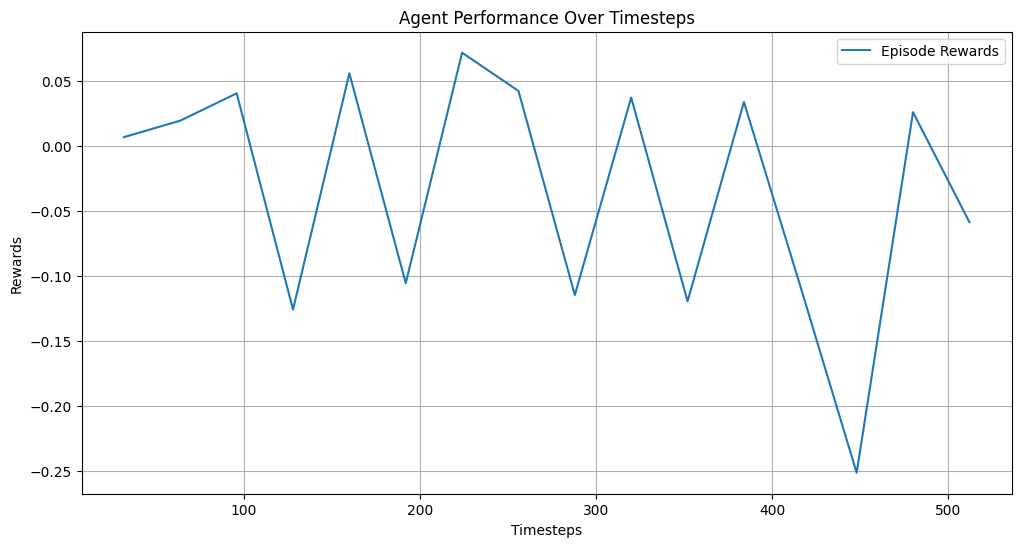

Performance for medium difficulty:


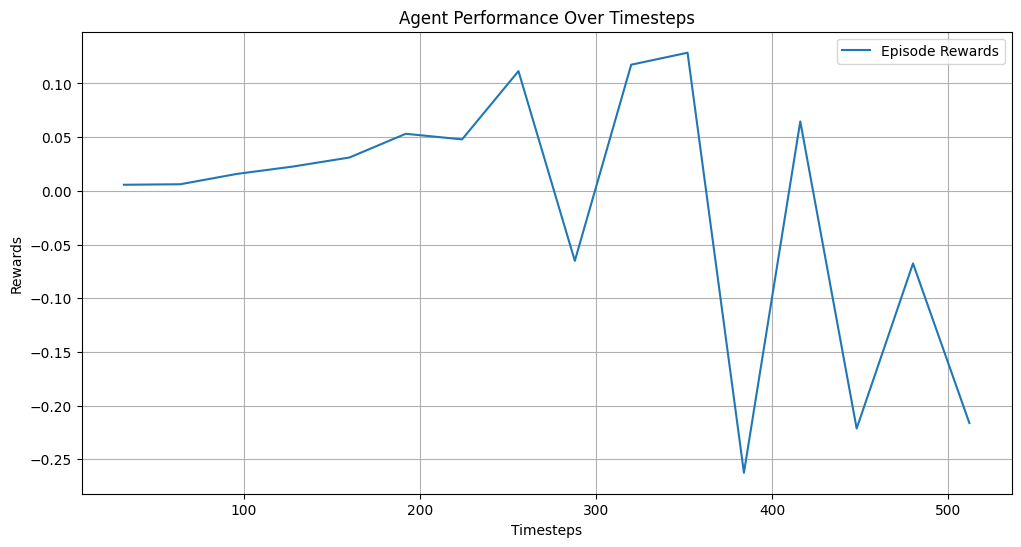

Performance for hard difficulty:


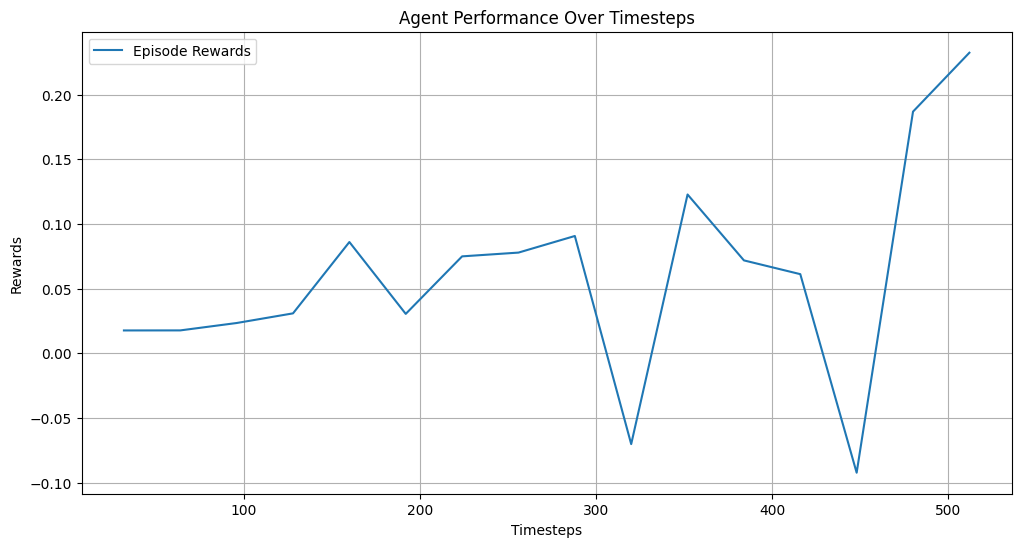

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Running Curriculum Experiment WITH Transfer Learning...
Training on easy difficulty (With Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 62 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 91          |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.008222368 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.348      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0176     |
|    n_updates            | 10          |
|    policy_gradien

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 301          |
|    ep_rew_mean          | 3.18         |
| time/                   |              |
|    fps                  | 117          |
|    iterations           | 10           |
|    time_elapsed         | 2            |
|    total_timesteps      | 320          |
| train/                  |              |
|    approx_kl            | 0.0077716317 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.0139       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00773     |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.0127      |
|    std                  | 0.995        |
|    value_loss           | 0.0644       |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 185          |
|    ep_rew_mean          | 0.558        |
| time/                   |              |
|    fps                  | 119          |
|    iterations           | 12           |
|    time_elapsed         | 3            |
|    total_timesteps      | 384          |
| train/                  |              |
|    approx_kl            | 0.0016949177 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.00263      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0542       |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00246     |
|    std                  | 0.994        |
|    value_loss           | 0.255        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 104          |
|    ep_rew_mean          | -1.57        |
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 13           |
|    time_elapsed         | 3            |
|    total_timesteps      | 416          |
| train/                  |              |
|    approx_kl            | 0.0011942256 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.00094      |
|    learning_rate        | 0.0003       |
|    loss                 | 3.17         |
|    n_updates            | 120          |
|    policy_gradient_loss | 0.0013       |
|    std                  | 0.994        |
|    value_loss           | 6.95         |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 97.6         |
|    ep_rew_mean          | -1.75        |
| time/                   |              |
|    fps                  | 117          |
|    iterations           | 16           |
|    time_elapsed         | 4            |
|    total_timesteps      | 512          |
| train/                  |              |
|    approx_kl            | 0.0001023002 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    explained_variance   | 0.00488      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0373       |
|    n_updates            | 150          |
|    policy_gradient_loss | -3.09e-05    |
|    std                  | 0.991        |
|    value_loss           | 0.125        |
------------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (With Transfer)...
Continuing training with transfer learning...
---------------------------
| time/              |    |
|    fps             | 67 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.006417265 |
|    clip_fraction        | 0.00625     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.00509    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.164       |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0166     |
|    std                  | 0.988    

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 164         |
|    ep_rew_mean          | 9.61        |
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 6           |
|    time_elapsed         | 1           |
|    total_timesteps      | 192         |
| train/                  |             |
|    approx_kl            | 0.010501722 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.000542   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.383       |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0292     |
|    std                  | 0.989       |
|    value_loss           | 1.51        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 72          |
|    ep_rew_mean          | 2.17        |
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 7           |
|    time_elapsed         | 2           |
|    total_timesteps      | 224         |
| train/                  |             |
|    approx_kl            | 0.021476252 |
|    clip_fraction        | 0.0875      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.000778    |
|    learning_rate        | 0.0003      |
|    loss                 | 3.44        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0151     |
|    std                  | 0.99        |
|    value_loss           | 6.94        |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 75.8        |
|    ep_rew_mean          | 3.87        |
| time/                   |             |
|    fps                  | 90          |
|    iterations           | 12          |
|    time_elapsed         | 4           |
|    total_timesteps      | 384         |
| train/                  |             |
|    approx_kl            | 0.004140351 |
|    clip_fraction        | 0.00937     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.0121      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.263       |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.0125     |
|    std                  | 0.989       |
|    value_loss           | 1.1         |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 70           |
|    ep_rew_mean          | 2.97         |
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 14           |
|    time_elapsed         | 4            |
|    total_timesteps      | 448          |
| train/                  |              |
|    approx_kl            | 0.0052017495 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.00854     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0649       |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.0107      |
|    std                  | 0.986        |
|    value_loss           | 0.263        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 59.9        |
|    ep_rew_mean          | 1.99        |
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 15          |
|    time_elapsed         | 5           |
|    total_timesteps      | 480         |
| train/                  |             |
|    approx_kl            | 0.012044935 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.000261   |
|    learning_rate        | 0.0003      |
|    loss                 | 4.74        |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0172     |
|    std                  | 0.986       |
|    value_loss           | 9.58        |
-----------------------------------------
-----------------------------------------
| rollout/                |       

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on hard difficulty (With Transfer)...
Continuing training with transfer learning...
---------------------------
| time/              |    |
|    fps             | 69 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 87           |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 64           |
| train/                  |              |
|    approx_kl            | 0.0010298584 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 0.0012       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.212        |
|    n_updates            | 330          |
|    policy_gradient_loss | 0.00292      |
|    std               

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 116           |
|    ep_rew_mean          | 16.2          |
| time/                   |               |
|    fps                  | 85            |
|    iterations           | 4             |
|    time_elapsed         | 1             |
|    total_timesteps      | 128           |
| train/                  |               |
|    approx_kl            | 0.00039777532 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.81         |
|    explained_variance   | 0.00527       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.23          |
|    n_updates            | 350           |
|    policy_gradient_loss | -0.00295      |
|    std                  | 0.984         |
|    value_loss           | 3.27          |
-------------------------------------------
--------------------------------

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 96           |
|    ep_rew_mean          | 14.2         |
| time/                   |              |
|    fps                  | 89           |
|    iterations           | 6            |
|    time_elapsed         | 2            |
|    total_timesteps      | 192          |
| train/                  |              |
|    approx_kl            | 0.0016509015 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.00371     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.681        |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.005       |
|    std                  | 0.985        |
|    value_loss           | 1.55         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 97.3         |
|    ep_rew_mean          | 13.4         |
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 10           |
|    time_elapsed         | 3            |
|    total_timesteps      | 320          |
| train/                  |              |
|    approx_kl            | 0.0008036997 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.00051     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.02         |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.00145     |
|    std                  | 0.985        |
|    value_loss           | 2.57         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 88          |
|    ep_rew_mean          | 12.6        |
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 11          |
|    time_elapsed         | 3           |
|    total_timesteps      | 352         |
| train/                  |             |
|    approx_kl            | 0.005817162 |
|    clip_fraction        | 0.00937     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.000258   |
|    learning_rate        | 0.0003      |
|    loss                 | 6.9         |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.00438    |
|    std                  | 0.982       |
|    value_loss           | 13.8        |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 81.4        |
|    ep_rew_mean          | 11.1        |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 13          |
|    time_elapsed         | 4           |
|    total_timesteps      | 416         |
| train/                  |             |
|    approx_kl            | 0.001254417 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.8        |
|    explained_variance   | 0.00475     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.28        |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.000612   |
|    std                  | 0.981       |
|    value_loss           | 2.62        |
-----------------------------------------
-------------------------------------------
| rollout/                |     

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 85            |
|    ep_rew_mean          | 12.2          |
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 16            |
|    time_elapsed         | 5             |
|    total_timesteps      | 512           |
| train/                  |               |
|    approx_kl            | 0.00036948547 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.8          |
|    explained_variance   | 0.000629      |
|    learning_rate        | 0.0003        |
|    loss                 | 2.08          |
|    n_updates            | 470           |
|    policy_gradient_loss | -0.000256     |
|    std                  | 0.98          |
|    value_loss           | 4.64          |
-------------------------------------------
Performance for easy difficulty:

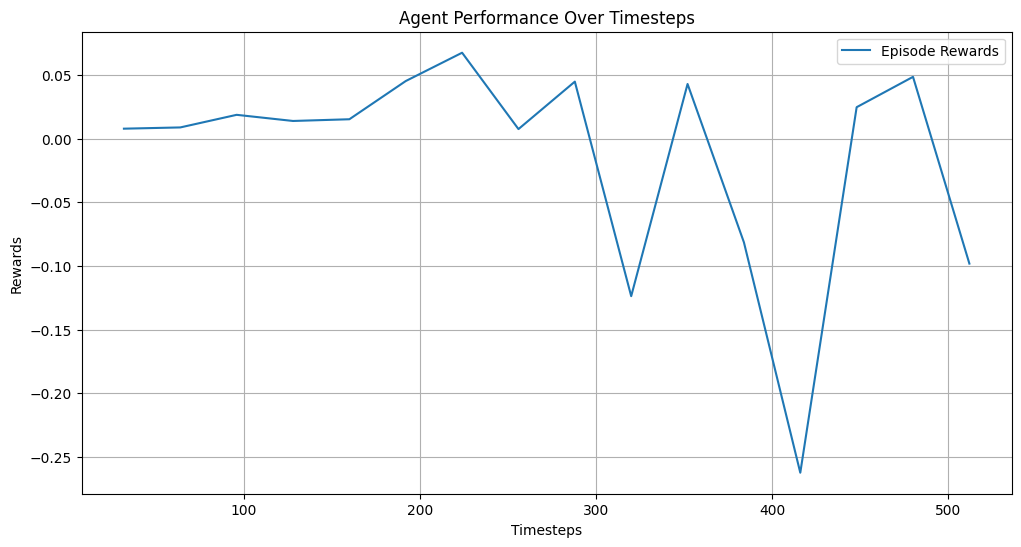

Performance for medium difficulty:


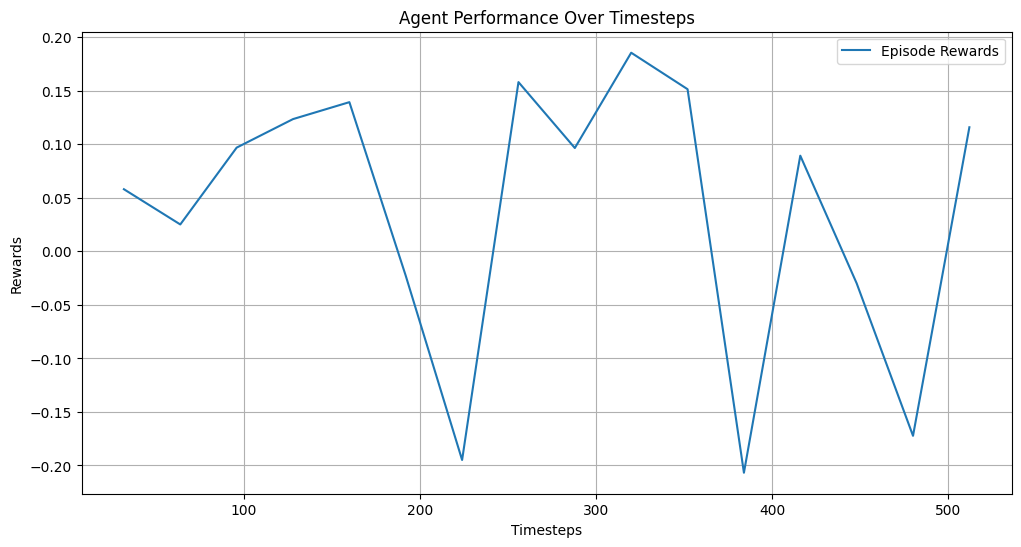

Performance for hard difficulty:


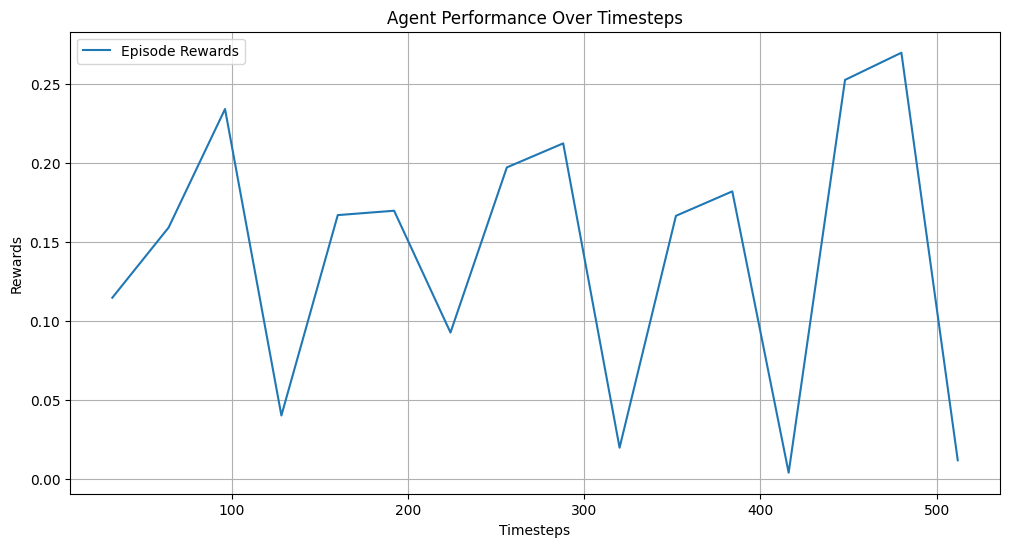

In [ ]:
# Run the curriculum experiments
difficulty_order = ["easy", "medium", "hard"]

# Experiment without transfer learning
print("Running Curriculum Experiment WITHOUT Transfer Learning...")
curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=500)

# Experiment with transfer learning
print("Running Curriculum Experiment WITH Transfer Learning...")
curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=500)

# Code for simulator, not tested

In [ ]:
from pyvirtualdisplay import Display

# Set up the virtual display
display = Display(visible=0, size=(972, 729))
display.start()

In [ ]:
def show_frame(env, step, interval=10):
    if step % interval == 0:  # Show every 'interval' steps
        base_env = env.unwrapped  # Access the underlying MetaDriveEnv
        frame = base_env.render(mode="rgb_array")
        if frame is None:
            print("[WARNING] Frame rendering failed. Ensure 'use_render=True' in the configuration.")
            return
        img = Image.fromarray(frame)
        clear_output(wait=True)
        display(img)

In [ ]:
def reset_environment(env, difficulty):
    base_env = env.unwrapped
    if difficulty == "easy":
        base_env.config.update({"map": 3, "traffic_density": 0.1, "random_lane_width": False, "use_render": False})
    elif difficulty == "medium":
        base_env.config.update({"map": 5, "traffic_density": 0.3, "random_lane_width": True, "use_render": False})
    elif difficulty == "hard":
        base_env.config.update({"map": 7, "traffic_density": 0.5, "random_lane_width": True, "use_render": False})
    base_env.reset()


In [ ]:
def evaluate_model_with_visualization(model, env, num_episodes=5):
  rewards = []
  for episode in range(num_episodes):
      obs, _ = env.reset()
      done = False
      total_reward = 0
      step = 0
      while not done:
          action, _ = model.predict(obs, deterministic=True)
          obs, reward, done, truncated, info = env.step(action)
          total_reward += reward
          show_frame(env, step)  # Display the frame every few steps
          step += 1
      rewards.append(total_reward)
  return rewards

SyntaxError: incomplete input (<ipython-input-14-59946a11ebd1>, line 1)

In [ ]:
def evaluate_and_save_video(model, env, num_episodes=1, output_dir="./video"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    frames = []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            frame = env.unwrapped.render(mode="rgb_array")
            if frame is not None:
                frames.append(Image.fromarray(frame))
        print(f"Episode {episode + 1} finished with total reward: {total_reward}")

    # Save video as GIF
    video_path = os.path.join(output_dir, "evaluation.gif")
    frames[0].save(
        video_path,
        save_all=True,
        append_images=frames[1:],
        duration=50,  # Duration of each frame in milliseconds
        loop=0,
    )
    print(f"Video saved at: {video_path}")

In [ ]:
def curriculum_experiment_reuse_env(order):
    """
    Runs a curriculum learning experiment using a single reusable environment.
    """
    results = []
    env = create_environment("easy", render=True)  # Use a single environment

    for difficulty in order:
        print(f"Training on {difficulty} difficulty...")
        reset_environment(env, difficulty)
        model = train_agent(env, timesteps=100)
        evaluate_and_save_video(model, env, num_episodes=1)  # Save video for 1 episode
        results.append((difficulty, [0]))  # Placeholder for rewards in quick test

    env.close()
    return results

In [ ]:
def summarize_results(results):
    """
    Summarizes the results of the experiment.
    """
    for difficulty, rewards in results:
        avg_reward = np.mean(rewards)
        std_reward = np.std(rewards)
        print(f"Difficulty: {difficulty}, Avg Reward: {avg_reward:.2f}, Std Dev: {std_reward:.2f}")

results = curriculum_experiment_reuse_env(["easy", "medium", "hard"])
summarize_results(results)

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3


Training on easy difficulty...


[INFO] Known Pipes: glxGraphicsPipe
[WARNING] Since your screen is too small (1080, 810), we resize the window to (972, 729). (engine_core.py:230)
[INFO] Start Scenario Index: 0, Num Scenarios : 1
